   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (USB Audio Device ), MME (2 in, 0 out)
   2 Stereo-mix (Realtek(R) Audio), MME (2 in, 0 out)
   3 Microphone Array (Realtek(R) Au, MME (2 in, 0 out)
   4 Microphone (Camo), MME (2 in, 0 out)
   5 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  6 Speaker/Headphone (Realtek(R) A, MME (0 in, 2 out)
   7 Speakers (USB Audio Device ), MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (USB Audio Device ), Windows DirectSound (2 in, 0 out)
  10 Stereo-mix (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  11 Microphone Array (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Microphone (Camo), Windows DirectSound (2 in, 0 out)
  13 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  14 Speaker/Headphone (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  15 Speakers (USB Audio Device ), Windows DirectSound (0 in, 2 out)
  16 ASIO4ALL v2, ASIO

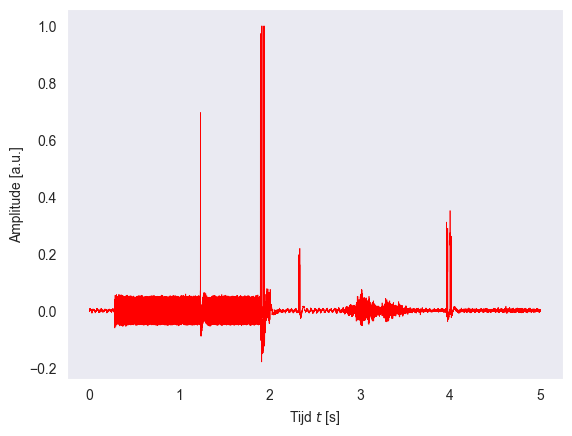

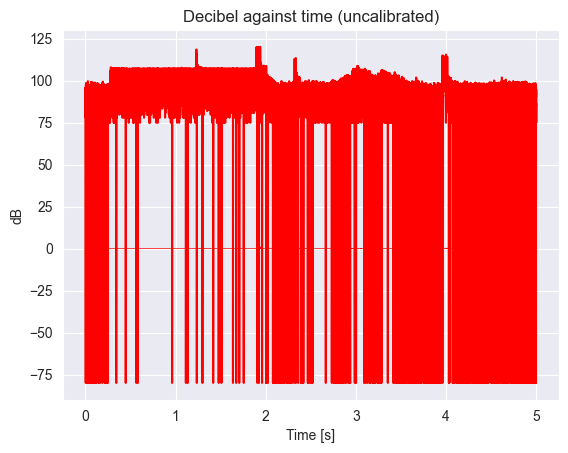

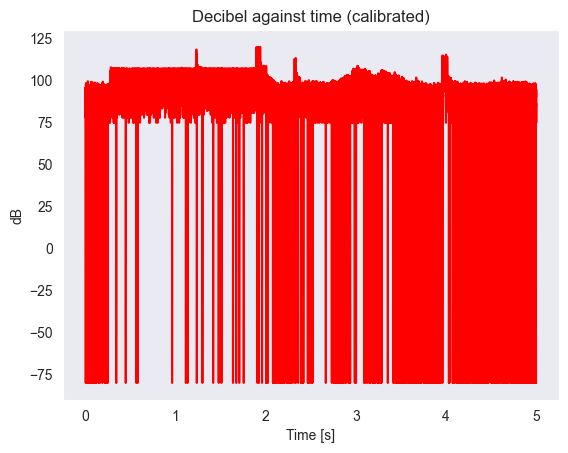

avg:57.779752386720354


In [60]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np

def debug_sound_devices():
    print(sd.query_devices()) # geeft een lijst met devices en de bijbehorende nummers

def record(_tone_duration, extra_duration):
    fs = 44100        # sampling frequency

    # Generate a 1 kHz sine wave tone for 1 second
    tone_samples = _tone_duration * fs
    freq = 180        # frequency of the tone in Hz
    time_array = np.arange(tone_samples) / fs
    tone = np.sin(2 * np.pi * freq * time_array)

    # Set the volume of the tone
    volume = 1       # set the volume to 50% of full volume

    # Start playing the sound and recording audio simultaneously
    indata = sd.playrec(volume * tone, samplerate=fs, channels=1)

    # Wait for the sound to finish playing
    sd.wait()

    # Continue recording for an additional 3 seconds
    extra_samples = extra_duration * fs
    extra_data = sd.rec(extra_samples, samplerate=fs, channels=1)
    sd.wait()

    _sound_stop_index = indata[:,0].size - 1

    # Concatenate the recorded audio data
    recording = np.concatenate((indata, extra_data))[:,0]
    _duration = _tone_duration + extra_duration
    return recording, _duration, _sound_stop_index, fs

def plot_amplitude_against_time(_duration, _fs, _values, _time_stamps):
    plt.figure(dpi=100)
    plt.plot(_time_stamps, _values, 'r-', ms=0.5, lw=0.5)
    plt.grid()
    plt.xlabel(r"Tijd $t$ [s]")
    plt.ylabel(r"Amplitude [a.u.]") # arbitrary units (we hebben niets gekalibreerd)

def calculate_decibels(_intensity_array):
    i_0 = 1e-12
    i = (_intensity_array + 1e-20)
    return 10 * np.log10(i / i_0)

def calibrate_decibels(_decibel_array, _decibel_coefficient, _decibel_offset):
    return (_decibel_array - _decibel_offset) / _decibel_coefficient

def plot_decibel_against_time(_time_stamps, _decibel_array, _title):
    # plt.figure(dpi=100)
    plt.plot(_time_stamps, _decibel_array, 'r-') # plot dB against time
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel("dB")
    plt.title(_title)
    plt.show()

debug_sound_devices()

# Step 1 record
values, total_duration, sound_stop_index, sample_rate = record(2, 3)
# Create time stamps for plotting
time_stamps = np.linspace(0, total_duration, int(sample_rate*total_duration))

# Debug amplitude against time
plot_amplitude_against_time(_duration=total_duration, _fs=sample_rate, _values=values, _time_stamps=time_stamps)

# Step 2: Convert to absolute values
absolute_values = np.absolute(values)
plot_amplitude_against_time(_duration=total_duration, _fs=sample_rate, _values=absolute_values, _time_stamps=time_stamps)

decibel_array = calculate_decibels(_intensity_array=absolute_values)
plot_decibel_against_time(_time_stamps=time_stamps, _decibel_array=decibel_array, _title="Decibel against time (uncalibrated)")

calibrated_decibel_array = calibrate_decibels(_decibel_array=decibel_array, _decibel_coefficient=0.4756, _decibel_offset=69.59)
plot_decibel_against_time(_time_stamps=time_stamps, _decibel_array=decibel_array, _title="Decibel against time (calibrated)")

print("avg:" + str(np.average(calibrated_decibel_array)))

avg:54.48498615594687
Before drop sound level: 70.60324380911489
Decay time: 0.0


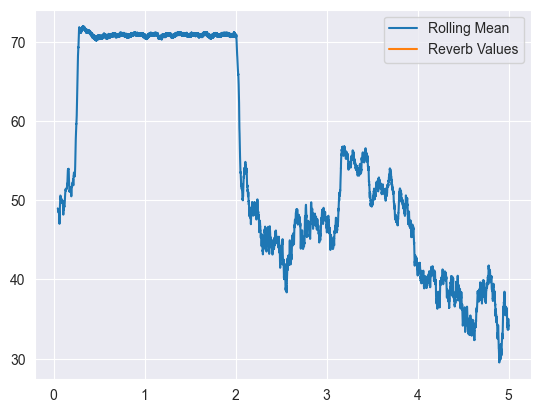

Nagalm tijd: 
-1.9999863944961203


In [59]:
import pandas as pd

def get_reverb_time(_time_stamps, _sound_stop_index, _decibel_array):
    # Find the maximum sound level in the decibel array
    sound_level_before_drop = _decibel_array[_sound_stop_index]

    print("Before drop sound level: " + str(sound_level_before_drop))

    # Find the index of the first data point where the sound level is 60 dB below the maximum sound level
    _decay_point_index = np.argmax((_decibel_array <= sound_level_before_drop - 52) & (_time_stamps > _time_stamps[_sound_stop_index]))

    print("Decay time: " + str(_time_stamps[_decay_point_index]))

    # Calculate the time it takes for the sound level to decay by 60 dB
    _reverb_time = _time_stamps[_decay_point_index] - _time_stamps[_sound_stop_index]

    return _reverb_time, _decay_point_index

# create a pandas dataframe with your time stamps and decibel values
df = pd.DataFrame({'Time': time_stamps, 'Decibels': calibrated_decibel_array})

# calculate a rolling mean with a window size of 100
rolling_mean = df['Decibels'].rolling(window=2000).mean()

df = pd.DataFrame({'Time': time_stamps, 'Decibels': calibrated_decibel_array, 'Rolling Mean': rolling_mean})

# plot the original data and the rolling mean
# plt.plot(df['Time'], df['Decibels'], label='Raw Data')
plt.plot(df['Time'], rolling_mean, label='Rolling Mean')
# plt.xlim(1.8, 5)

print("avg:" + str(np.average(calibrated_decibel_array)))

reverb_time, decay_point_index = get_reverb_time(_time_stamps=df['Time'], _decibel_array=rolling_mean, _sound_stop_index=sound_stop_index)

# Select the rows in the DataFrame that fall within the time range
time_range_data = df.loc[(df['Time'].index >= sound_stop_index) & (df['Time'].index <= decay_point_index)]

# Extract the time and decibel values into separate arrays
time_range_times = time_range_data['Time'].values
time_range_decibels = time_range_data['Rolling Mean'].values

plt.plot(time_range_times, time_range_decibels, label='Reverb Values')
plt.legend()
plt.show()

print("Nagalm tijd: ")
print(str(reverb_time))

In [52]:
df.to_csv('metingen\kleine_kamer_punt_4_180Hz.csv', index=False)

In [118]:
import seaborn as sns

dfs = []

def generate(dfs):
    # Create a grid of subplots with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    fig.tight_layout(pad=2)

    for i in range(len(dfs)):
        df = dfs[i]
        df_matrix = df.pivot("x (m)", "y (m)", "nagalmtijd (s)")

        # Plot the heatmap with origin in the left corner
        sns.heatmap(df_matrix, cmap="YlGnBu", annot=True, fmt=".1f", cbar=False, ax=axs[i])
        axs[i].set_title("Heatmap " + str(i + 1))
        axs[i].set_xlabel("X-axis (m)")
        axs[i].set_ylabel("Y-axis (m)")

    # Add a colorbar for all heatmaps
    cbar = fig.colorbar(axs[0].collections[0], ax=axs, location="right", shrink=1)
    cbar.ax.set_ylabel("Nagalmtijd (s)", rotation=270, labelpad=20)

    plt.show()


generate([df_a, df_b, df_c])